In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils import preprocess

In [2]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
DATA_DIR = './data/'
IMG_DIR = './img/'
PROCESSED_DATA_DIR = './processed_data/'

TRAIN_FILE = DATA_DIR + 'train.csv'
TEST_FILE = DATA_DIR + 'test.csv'

PROCESSED_TRAIN_FILE = PROCESSED_DATA_DIR + 'processed_train.csv'
PROCESSED_TEST_FILE = PROCESSED_DATA_DIR + 'processed_test.csv'
PROCESSED_RECOMMENDATION_TRAIN_FILE = PROCESSED_DATA_DIR + 'processed_recommendation_train.csv'

AUX_DATA_DIR = DATA_DIR + 'auxiliary-data/'
SUBZONE_FILE = AUX_DATA_DIR + 'sg-subzones.csv'
COMMERCIAL_CENTER_FILE = AUX_DATA_DIR + 'sg-commerical-centres.csv'
MRT_FILE = AUX_DATA_DIR + 'sg-mrt-stations.csv'
PRIMARY_SCHOOL_FILE = AUX_DATA_DIR + 'sg-primary-schools.csv'
SECONDARY_SCHOOL_FILE = AUX_DATA_DIR + 'sg-secondary-schools.csv'
SHOPPING_MALL_FILE = AUX_DATA_DIR + 'sg-shopping-malls.csv'

COMMERCIAL_CENTER_DIS_FILE = PROCESSED_DATA_DIR + 'sg-commerical-centres.npy'
MRT_DIS_FILE = PROCESSED_DATA_DIR + 'sg-mrt-stations.npy'
PRIMARY_SCHOOL_DIS_FILE = PROCESSED_DATA_DIR + 'sg-primary-schools.npy'
SECONDARY_SCHOOL_DIS_FILE = PROCESSED_DATA_DIR + 'sg-secondary-schools.npy'
SHOPPING_MALL_DIS_FILE = PROCESSED_DATA_DIR + 'sg-shopping-malls.npy'

# EDA

### Overview

In [4]:
df_train_original = pd.read_csv(TRAIN_FILE)
df_train_original.head()

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
0,122881,hdb flat for sale in 866 yishun street 81,sembawang / yishun (d27),866 yishun street 81,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,...,unspecified,NaN,116.0,https://www.99.co/singapore/hdb/866-yishun-str...,1.414399,103.837196,0,yishun south,yishun,514500.0
1,259374,hdb flat for sale in 506b serangoon north aven...,hougang / punggol / sengkang (d19),hdb-serangoon estate,hdb,99-year leasehold,1992.0,4.0,2.0,1575,...,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/hdb/hdbserangoon-e...,1.372597,103.875625,0,serangoon north,serangoon,995400.0
2,665422,4 bed condo for sale in meyerhouse,128 meyer road,meyerhouse,condo,freehold,2022.0,4.0,6.0,3070,...,partial,"studio, 3, 4, 5, 6 br",56.0,https://www.99.co/singapore/condos-apartments/...,1.298773,103.895798,0,mountbatten,marine parade,8485000.0
3,857699,3 bed condo for sale in leedon green,26 leedon heights,leedon green,Condo,freehold,2023.0,3.0,2.0,958,...,partial,"studio, 1, 2, 3, 4 br",638.0,https://www.99.co/singapore/condos-apartments/...,1.312364,103.803271,0,farrer court,bukit timah,2626000.0
4,216061,2 bed condo for sale in one bernam,1 bernam street,one bernam,condo,99-year leasehold,2026.0,2.0,1.0,732,...,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,https://www.99.co/singapore/condos-apartments/...,1.273959,103.843635,0,anson,downtown core,1764000.0


### Feature selection

After taking an overview of the dataset, we decide to only utilize certain columns as our features. Below are the columns we wish to **drop** and a short explanation on why we choose to do so:
- listing_id: This is an artificial indentifier.
- title: Information is overloaded. The same set of information can be retrieved from other columns and it will be more organized.
- address: 1. Data is inconsistent: some are road with block numbers, some are districts. 2. Too many values, hard to encode.
- property_name: Too many values, hard to encode.
- floor_level: highly homogeneous, most values are NA.
- elevation: extremely homogeneous, all values are 0.
- available_unit_types: information overloaded, hard to encode.
- total_num_units: We believe it has very little contribution to the resale price.
- furnishing: highly homogeneous, most values are unspecified.
- property_details_url: It does not reveal anything about the property.

Those columns will be dropped in later preprocessing step.

### property_type

1. Values need to be normalized.
2. For HDBs, we want to avoid the information overload. So we will remove how many rooms from the type and only keep the value of HDB.

In [5]:
df_train_original['property_type'].unique()

array(['hdb 4 rooms', 'hdb', 'condo', 'Condo', 'bungalow', 'Hdb',
       'terraced house', 'Hdb Executive', 'apartment',
       'Semi-Detached House', 'Apartment', 'Hdb 4 Rooms',
       'semi-detached house', 'hdb 3 rooms', 'executive condo',
       'corner terrace', 'hdb executive', 'Hdb 3 Rooms', 'Hdb 5 Rooms',
       'hdb 5 rooms', 'landed', 'hdb 2 rooms', 'Executive Condo',
       'Bungalow', 'Corner Terrace', 'Terraced House', 'cluster house',
       'Cluster House', 'Land Only', 'townhouse', 'Hdb 2 Rooms',
       'conservation house', 'land only', 'walk-up', 'Townhouse',
       'Conservation House', 'good class bungalow', 'Landed', 'shophouse'],
      dtype=object)

In [6]:
preprocess.process_property_type(df_train_original)
df_train_original['property_type'].unique()

array(['hdb', 'condo', 'bungalow', 'terraced house', 'apartment',
       'semi-detached house', 'executive condo', 'corner terrace',
       'landed', 'cluster house', 'land only', 'townhouse',
       'conservation house', 'walk-up', 'good class bungalow',
       'shophouse'], dtype=object)

### tenure

According to Singapore Government, there are only three types of valid tenure: 99-year, 999-year and freehold. So we will map the values to those three types based on the most similar lease length. For NA values, we will discuss how to fill them in pre-processing steps.

In [7]:
df_train_original['tenure'].unique()

array([nan, '99-year leasehold', 'freehold', '999-year leasehold',
       '110-year leasehold', '946-year leasehold', '103-year leasehold',
       '956-year leasehold', '929-year leasehold', '102-year leasehold',
       '100-year leasehold', '947-year leasehold'], dtype=object)

### built_year

For built years, there aren't many things to care about. The only thing we need to pay attention to is how to fill the NA values and it will be discussed in pre-processing.

In [8]:
df_train_original['built_year'].sort_values().unique()

array([1963., 1967., 1968., 1969., 1970., 1971., 1972., 1973., 1974.,
       1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982., 1983.,
       1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992.,
       1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001.,
       2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
       2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.,
       2020., 2021., 2022., 2023., 2024., 2025., 2026., 2027., 2028.,
         nan])

### num_beds & num_baths

We can see majority of the combinations of bedroom number and bathroom number is fine. Later in preprocessing we will only take care of the two outliers, (1 bedroom + 10 bathrooms) and (10 bedrooms + 1 bathroom). How to fill NA values will be discussed in preprocessing steps.

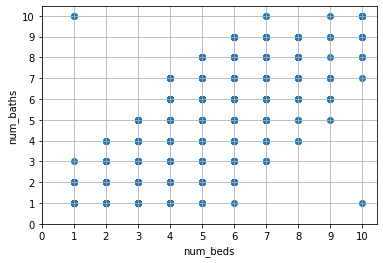

In [9]:
beds_baths_mask = (~df_train_original['num_beds'].isna()) & (~df_train_original['num_baths'].isna())
df_train_for_rooms = df_train_original[beds_baths_mask]
num_beds = df_train_for_rooms['num_beds'].to_list()
num_baths = df_train_for_rooms['num_baths'].to_list()
plt.scatter(num_beds, num_baths)
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 11, 1))
plt.grid()
plt.xlabel('num_beds')
plt.ylabel('num_baths')
plt.show()

### Latitude & Longitude

The most intuitive way to visualize latitudes and longitudes is plotting them like a map! Apart from just showing the location distribution of our whole dataset, we also want to know the density. So we use Kernel Density Estimation to calculate the probability density for each location and use it as the color coding. The brighter the point, the denser the properties in that area!

Since we want to save your time for calculating the kernel density, we save the images beforehand. If you want to plot them, just un-comment the two functions below.

From the original plot on the left, we can immediatly tell some locations are wrong. In fact the most dense point (the yellow point) should be all correct locations in Singapore. Other locations are wrong due to data collection issues. After looking into those data, we find they are all from four condos, so we decide to do a manual lookup from Google Maps to correct them. After fixing them, we can see the updated plot on the right, and it indeed shows the perfect match to Singapore territory.

In [10]:
lat_array = df_train_original['lat'].to_numpy()
lng_array = df_train_original['lng'].to_numpy()
# preprocess.save_geo_scatter_plot(lat_array, lng_array, IMG_DIR + 'geo_coordinates_density_plot_pre.png')

preprocess.fix_abnormal_geo_location(df_train_original)
new_lat_array = df_train_original['lat'].to_numpy()
new_lng_array = df_train_original['lng'].to_numpy()
# preprocess.save_geo_scatter_plot(new_lat_array, new_lng_array, IMG_DIR + 'geo_coordinates_density_plot_post.png')

<img src="img/geo_coordinates_density_plot_pre.png" width="45%"> <img src="img/geo_coordinates_density_plot_post.png" width="45%">

### subzone & planning_area

They have a hierachical structure as planning_area -> subzone. The only thing we need to solve is the NA values. Since we have complete and correct data for latitudes and longitudes now, we can use these two features to construct a KNN classifier to find the missing subzone values. This is geographically practical as the property should be within the same subzone area in its vicnity. After getting all subzones, we can map the planning_area according to subzone as they have the hierachical structure. The code will be implemented in preprocessing steps.

In [11]:
print('NA values in subzone:', 'Yes' if df_train_original['subzone'].isna().any() else 'No')
print('NA values in planning_area:', 'Yes' if df_train_original['planning_area'].isna().any() else 'No')

NA values in subzone: Yes
NA values in planning_area: Yes


### size_sqft & price

These two columns should be most important in the resale price prediction task. The price is the label, and the size_sqft should be considerably the lasgest contributing factor to the label. The understanding and processing of these two columns are extremely challenging because there is a very wide variation. Some prices may be normal for a bungalow, but it would be an outlier for a hdb. Similarly, some sizes in sqft might be normal to a landed house, but it would be again an outlier for a hdb. Thus, the optimal way to analyze the data is to divide them by property types.

In [12]:
df_train_original['property_type'].value_counts()

condo                  9648
hdb                    6332
semi-detached house    1018
executive condo        1010
bungalow                747
apartment               540
terraced house          446
corner terrace          255
cluster house           184
conservation house       21
landed                   20
walk-up                  16
townhouse                 9
good class bungalow       5
land only                 2
shophouse                 1
Name: property_type, dtype: int64

To avoid big property with low price or small property with high price, we are specifically interest in the price per sqft. It should be a more accurate measure. What we are doing here is to interatively plot the price per sqft in histogram for each type and identify the outliers. How we handle those outliers will be discussed in preprocessing.

In [13]:
# remove 0 price rows
preprocess.remove_price_zero_records(df_train_original)
# size_sqft
preprocess.fill_zero_sqft(df_train_original)
preprocess.fix_abnormal_sqft(df_train_original)
preprocess.convert_sqm_to_sqft(df_train_original)
# price
preprocess.fix_super_high_price(df_train_original)
# add price_per_sqft for plotting
df_train_original['price_per_sqft'] = df_train_original['price'] / df_train_original['size_sqft']

After fixing all the outliers, we will plot the histogram to check whether it is a bell-curve like shape for each property type. But we can only do it for those property types with adequate number of candidates. So we choose nine types to plot below. There are so few candidates in other types (shown above) so we skip the plotting.

P.S. There is an exception in the plot for bungalow, but after we look into the data and research online, we find the data samples are actually credible. Maybe some bungalows just have this kind of sky high price per sqft :)

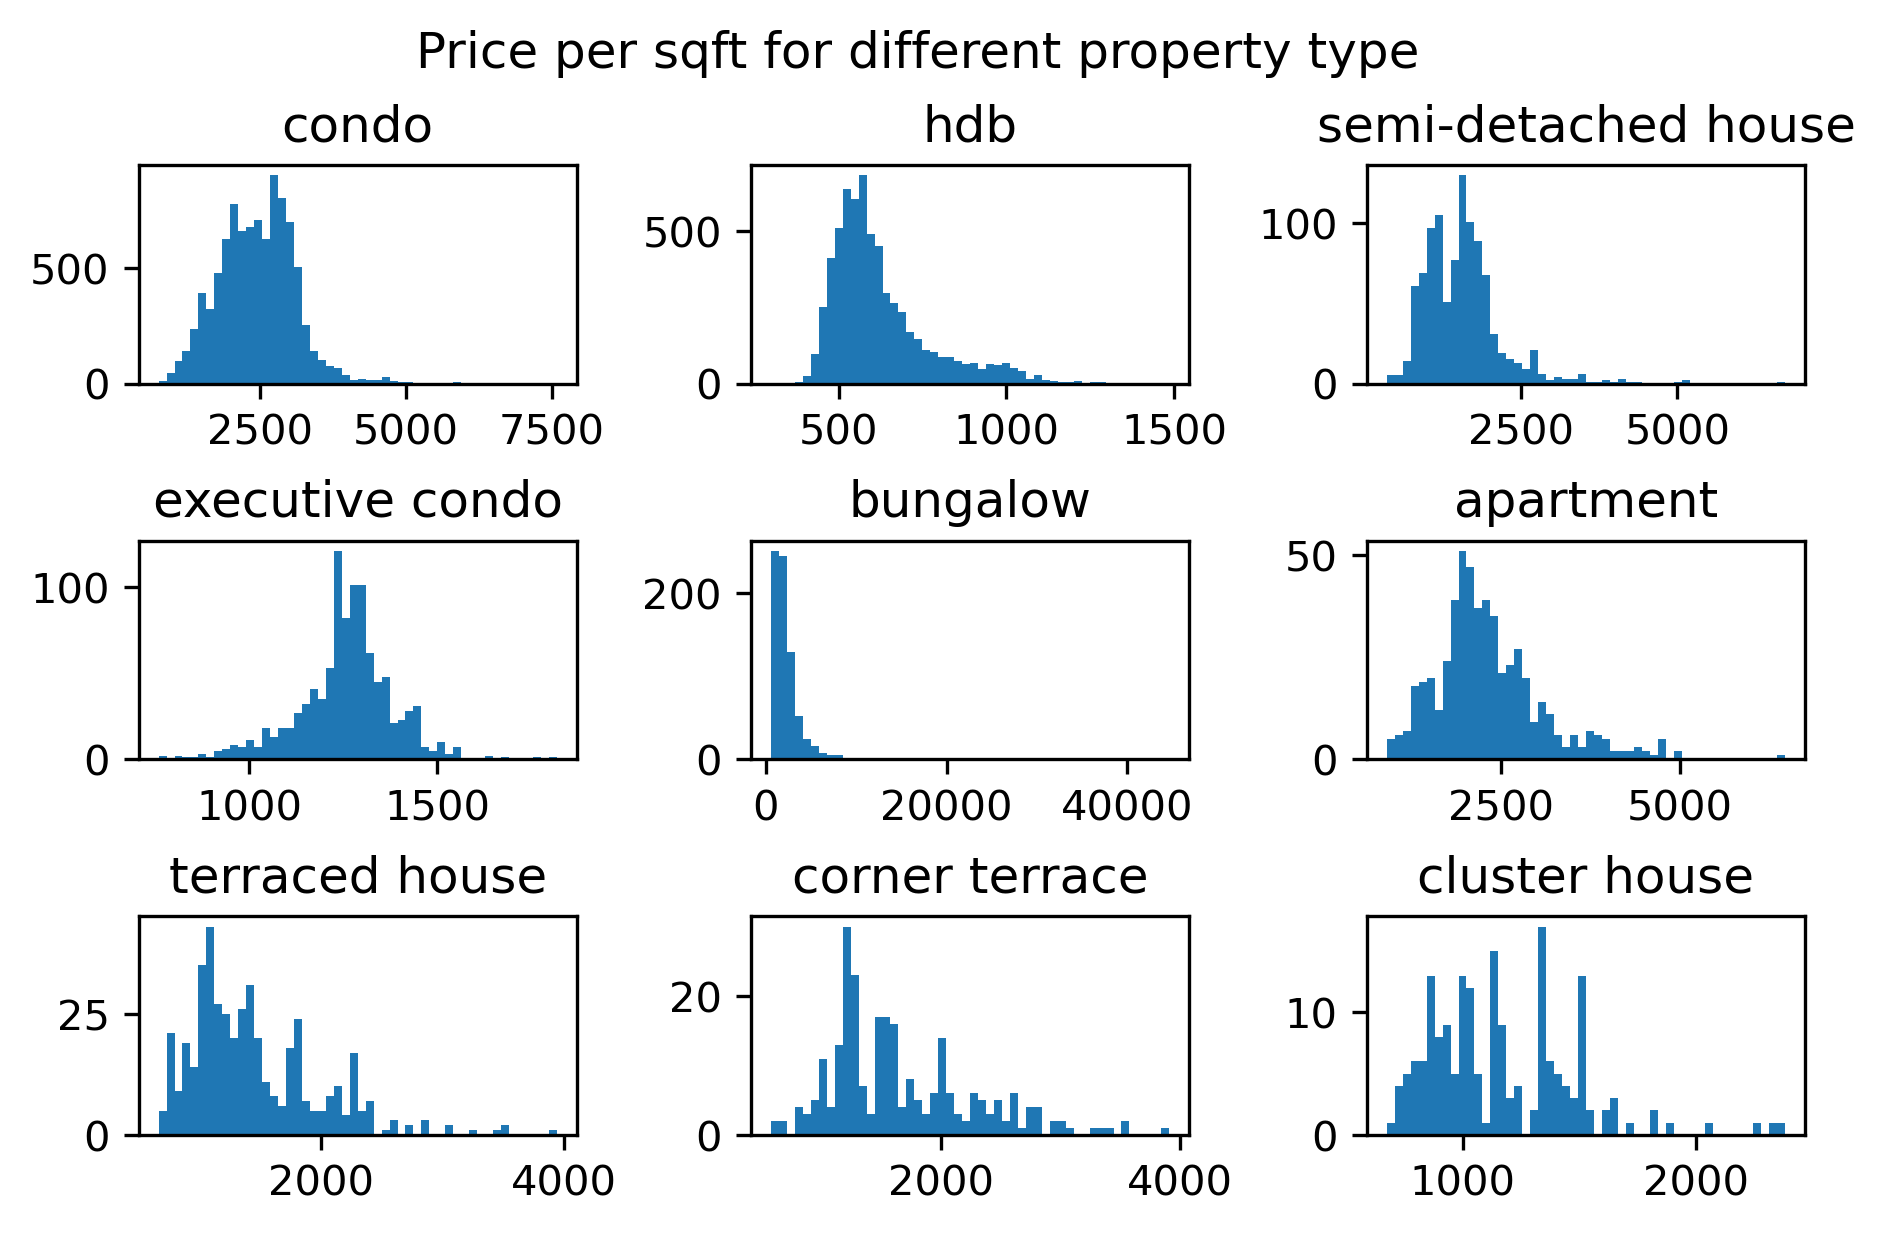

In [14]:
property_type_matrix = np.array([['condo', 'hdb', 'semi-detached house'], 
                                 ['executive condo', 'bungalow', 'apartment'], 
                                 ['terraced house', 'corner terrace', 'cluster house']])
fig, axs = plt.subplots(property_type_matrix.shape[0], property_type_matrix.shape[1], layout="constrained", dpi=300)
fig.suptitle('Price per sqft for different property type')
it = np.nditer(property_type_matrix, flags=['multi_index'])
for property_type in it:
    multi_index = it.multi_index
    data_array = df_train_original[df_train_original['property_type'] == property_type]['price_per_sqft'].to_numpy()
    axs[multi_index[0], multi_index[1]].hist(data_array, bins=50)
    axs[multi_index[0], multi_index[1]].set_title(str(property_type))

# Preprocess

Following data will be used in later encoding steps.

In [15]:
YEAR_BINS = pd.IntervalIndex.from_tuples([(0, 1980), (1980, 1990), (1990, 2000), (2000, 2010), (2010, 2020), (2020, 3000)])
YEAR_LABELS = dict(zip(YEAR_BINS, ['y0','y1','y2','y3','y4','y5']))
YEAR_DICT = { 'y0': 0., 'y1': 1., 'y2': 2., 'y3': 3., 'y4': 4., 'y5': 5. }

In [16]:
df_subzone = pd.read_csv(SUBZONE_FILE)
PLANNING_AREA_LIST = df_subzone['planning_area'].unique()

Load the train/test data.

In [17]:
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

### Preprocess df_train

We will preprocess the size_sqft, price, num_beds separately for train and test.
For train data, following preprocessing is done:
- num_beds: 1. For some studios, fill the number with 0, this is contextually correct as studio type means there is no separate bedrooms; 2. For some super big studios, it is actually the kind of project that allow the owner to configure the number of bedrooms themselves, so we just fill the number same as the bathrooms; 3. For special properties, we manually look up online and fill them.
- size_sqft: 1. For NA value, we found there is only one entry, so we manually lookup and fill; 2. For some areas, they are so small as if they are in sqm, so we convert them back to sqft; 3. We refer to EDA last step and iteratively fix abnormal size_sqft values based on the histogram.
- price: 1. All data entries with zero price are removed. 2. We refer to EDA last step and iteratively fix abnormal price values based on the histogram.

In [18]:
# size_sqft
preprocess.fill_zero_sqft(df_train)
preprocess.fix_abnormal_sqft(df_train)
preprocess.convert_sqm_to_sqft(df_train)
# num_beds
preprocess.fill_na_num_beds(df_train)
# fix odd num_baths
preprocess.fix_abnormal_beds_baths_number(df_train)
# remove 0 price rows
preprocess.remove_price_zero_records(df_train)
# price
preprocess.fix_super_high_price(df_train)

### Preprocess df_test

- num_beds: Follow the same procedure as training data.
- size_sqft: 1. For some areas, they are so small as if they are in sqm, so we convert them back to sqft; 2. For finding abnormal values, the process is similar to the histogram process as training data. But we don't have the price for test data. Thus the histogram is plotting the area size only.

In [19]:
# size_sqft
preprocess.convert_sqm_to_sqft_for_test(df_test)
preprocess.fix_abnormal_sqft_for_test(df_test)
# num_beds
preprocess.fill_na_num_beds_for_test(df_test)

### Combine & Preprocess

In [20]:
# assign an invalid price to test data, combine train/test data together for preprocess
df_test['price'] = -1.
train_test_delimiter = len(df_train)
df_all = pd.concat((df_train, df_test))

Following are preprocessing steps other columns:
- num_baths: To fill NA values, we group by num_beds and select the most common value in the num_beds group to assign for missing num_bath value.
- property_type: Same as described in EDA.
- tenure: 1. Same as described in EDA; 2. To fill NA values, we group by property_type and then assign the missing tenure value randomly. The probability is proportional to the size of a tenure in a particular property_type group.
- built_year: To fill NA values, 1. We first try to look for same property_name, same project should have a consistent built_year; 2. We want to do the same handling as tenure if same property_name does not present. But there are simple too many years... Thus we discretize the year to 10-year interval and do the same filling method as tenure; 3. After that, we find a special property_type conservation house. They are all historical buildings and so we just assign the oldest discretized year interval.
- lat & lng: Same as described in EDA.
- subzone: Same as described in EDA.
- planning_area: Same as described in EDA.

In [21]:
# fixed random for preprocessing
np.random.seed(5228)

# num_baths, for both train/test
preprocess.map_value_by_most_common(df_all, 'num_baths', 'num_beds')
# property_type
preprocess.process_property_type(df_all)
# tenure
preprocess.universalize_tenure(df_all)
# tenure fill na
preprocess.fillna_by_grouping(df_all, 'tenure', 'property_type')
# built year
preprocess.fillna_by_property_name(df_all, 'built_year')
preprocess.discretize_built_year(df_all, YEAR_BINS, YEAR_LABELS)
# built year fill na
preprocess.fillna_by_grouping(df_all, 'built_year', 'property_type')
preprocess.fill_conservation_house_built_year(df_all, 'y0')
# lat & lng
preprocess.fix_abnormal_geo_location(df_all)
# subzone
preprocess.map_subzone_by_geo_location_knn(df_all)
# planning_area
preprocess.map_value_by_most_common(df_all, 'planning_area', 'subzone')

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Process Auxiliary Data

We decide to utilize the auxiliary data by calculating the distance between the property and those commercial centers, schools, etc.

In [22]:
# property location data frame
df_property_name_location = df_all.groupby(['property_name']).agg(lat=('lat', 'mean'), lng=('lng', 'mean'))

In [23]:
df_commercial_center = pd.read_csv(COMMERCIAL_CENTER_FILE)
df_mrt = pd.read_csv(MRT_FILE)
df_primary_school = pd.read_csv(PRIMARY_SCHOOL_FILE)
df_secondary_school = pd.read_csv(SECONDARY_SCHOOL_FILE)
df_shopping_mall = pd.read_csv(SHOPPING_MALL_FILE)

Feel free to un-comment below code to re-calculate the distance, or you can just use the calculated ones stored in the file.

In [24]:
# # commercial center
# distance_commercial_center = preprocess.calculate_distance_km(df_property_name_location, df_commercial_center)
# np.save(COMMERCIAL_CENTER_DIS_FILE, distance_commercial_center)
# # mrt
# distance_mrt = preprocess.calculate_distance_km(df_property_name_location, df_mrt)
# np.save(MRT_DIS_FILE, distance_mrt)
# # primary school
# distance_primary_school = preprocess.calculate_distance_km(df_property_name_location, df_primary_school)
# np.save(PRIMARY_SCHOOL_DIS_FILE, distance_primary_school)
# # secondary school
# distance_secondary_school = preprocess.calculate_distance_km(df_property_name_location, df_secondary_school)
# np.save(SECONDARY_SCHOOL_DIS_FILE, distance_secondary_school)
# # shopping mall
# distance_shopping_mall = preprocess.calculate_distance_km(df_property_name_location, df_shopping_mall)
# np.save(SHOPPING_MALL_DIS_FILE, distance_shopping_mall)

In [25]:
distance_commercial_center = np.load(COMMERCIAL_CENTER_DIS_FILE)
distance_mrt = np.load(MRT_DIS_FILE)
distance_primary_school = np.load(PRIMARY_SCHOOL_DIS_FILE)
distance_secondary_school = np.load(SECONDARY_SCHOOL_DIS_FILE)
distance_shopping_mall = np.load(SHOPPING_MALL_DIS_FILE)

For different kinds of targets (schools/mrt/shopping mall), we use the number of those targets within a certain range as a new feature for the property. Additionaly, we add the distance to nearest MRT station also.

In [26]:
# comercial center
preprocess.populate_num_targets_within_range(df_all, df_property_name_location, distance_commercial_center, 0, 5, 'num_cc_5km')
# mrt
preprocess.populate_num_targets_within_range(df_all, df_property_name_location, distance_mrt, 0, 0.8, 'num_mrt_800m')
preprocess.populate_distance_to_nearest_target(df_all, df_property_name_location, distance_mrt, 'nearest_mrt_km')
# primary school
preprocess.populate_num_targets_within_range(df_all, df_property_name_location, distance_primary_school, 0, 1, 'num_ps_1km')
preprocess.populate_num_targets_within_range(df_all, df_property_name_location, distance_primary_school, 1, 2, 'num_ps_1km_to_2km')
# secondary school
preprocess.populate_num_targets_within_range(df_all, df_property_name_location, distance_secondary_school, 0, 1, 'num_ss_1km')
preprocess.populate_num_targets_within_range(df_all, df_property_name_location, distance_secondary_school, 1, 2, 'num_ss_1km_to_2km')
# shopping mall
preprocess.populate_num_targets_within_range(df_all, df_property_name_location, distance_shopping_mall, 0, 3, 'num_sm_3km')
# rearrange_columns
df_all = preprocess.move_price_to_last_column(df_all)

### Drop unused columns

In [27]:
dropped_columns = [
    "title", 
    "address",
    "property_name",
    "floor_level", 
    "elevation", 
    "available_unit_types", 
    "total_num_units", 
    "furnishing", 
    "available_unit_types", 
    "property_details_url",
]
df_all.drop(columns=dropped_columns, inplace=True)

### Encode Categorical Features

built_year and tenure are ordinal encoded. planning_area and property_type are one-hot encoded.

In [28]:
# built_year
preprocess.encode_built_year(df_all, YEAR_DICT)
# tenure
preprocess.encode_tenure(df_all)
# planning_area
df_all = preprocess.encode_planning_area(df_all, PLANNING_AREA_LIST)
# property_type
df_all = preprocess.encode_property_type(df_all)

In [29]:
# split train/test
df_train = df_all[:train_test_delimiter].copy()
df_test = df_all[train_test_delimiter:].copy()
df_test.drop(columns=['price'], inplace=True)

We further target encode the combination of subzone and property_type. Price per sqft is used as our traget when encoding. And test data are encoded by using the price per sqft from train data.

In [30]:
# generate encoding dict for test
subzone_encoding_dict = preprocess.generate_subzone_encoding_map(df_train)
property_type_encoding_dict = preprocess.generate_property_type_encoding_map(df_train)
# subzone, property_type
# train
subzone_property_type_encoding_dict = preprocess.target_encode_property_type_subzone(df_train)
# test
preprocess.target_encode_property_type_subzone_for_test(df_test, subzone_property_type_encoding_dict, subzone_encoding_dict, property_type_encoding_dict)

In [31]:
# rearrange columns to put one hot encoding at last place
df_train = preprocess.rearrange_columns(df_train)
df_test = preprocess.rearrange_columns(df_test)

Un-comment below saving csv line of code to replace the processed data for recommendation engine.

In [32]:
# for recommender system
df_train_recommendation = df_train.copy()
Path(PROCESSED_DATA_DIR).mkdir(parents=True, exist_ok=True)
# df_train_recommendation.to_csv(PROCESSED_RECOMMENDATION_TRAIN_FILE, index=False)

# drop listing id after preparing recommdation related data
df_train.drop(columns=['listing_id'], inplace=True)
df_test.drop(columns=['listing_id'], inplace=True)

Below is a final peak of our processed data.

In [33]:
df_train.head()

,tenure,built_year,num_beds,num_baths,size_sqft,lat,lng,subzone_property_type_encoding,num_cc_5km,num_mrt_800m,...,pt_executive_condo,pt_good_class_bungalow,pt_hdb,pt_land_only,pt_landed,pt_semi-detached_house,pt_shophouse,pt_terraced_house,pt_townhouse,pt_walk-up
0,0.0,1.0,3.0,2.0,1115.0,1.414399,103.837196,568.125814,3,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,4.0,2.0,1575.0,1.372597,103.875625,609.170390,8,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,5.0,4.0,6.0,3070.0,1.298773,103.895798,2664.659388,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,5.0,3.0,2.0,958.0,1.312364,103.803271,2907.132520,8,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.0,2.0,1.0,732.0,1.273959,103.843635,3085.236556,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df_test.head()

,tenure,built_year,num_beds,num_baths,size_sqft,lat,lng,subzone_property_type_encoding,num_cc_5km,num_mrt_800m,...,pt_executive_condo,pt_good_class_bungalow,pt_hdb,pt_land_only,pt_landed,pt_semi-detached_house,pt_shophouse,pt_terraced_house,pt_townhouse,pt_walk-up
20153,2.0,5.0,1.0,1.0,463.0,1.344334,103.878690,2211.844028,7,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20154,0.0,4.0,3.0,3.0,1033.0,1.380281,103.943878,1325.692993,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20155,0.0,3.0,1.0,1.0,570.0,1.294668,103.850074,1879.354291,4,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20156,0.0,4.0,3.0,2.0,1216.0,1.373120,103.746094,546.361513,2,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20157,0.0,0.0,3.0,2.0,936.0,1.341468,103.849047,660.515132,4,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
print('Records with NA value in train data:', len(df_train[df_train.isna().any(axis=1)]))
print('Records with NA value in test data:', len(df_test[df_test.isna().any(axis=1)]))

Records with NA value in train data: 0
Records with NA value in test data: 0


Un-comment below saving csv line of code to replace the processed data for resale price predictor.

In [36]:
Path(PROCESSED_DATA_DIR).mkdir(parents=True, exist_ok=True)
# df_train.to_csv(PROCESSED_TRAIN_FILE, index=False)
# df_test.to_csv(PROCESSED_TEST_FILE, index=False)